<a href="https://jupyterhub.user.eopf.eodc.eu/hub/login?next=%2Fhub%2Fspawn%3Fnext%3D%252Fhub%252Fuser-redirect%252Fgit-pull%253Frepo%253Dhttps%253A%252F%252Fgithub.com%252Feopf-toolkit%252Feopf-101%2526branch%253Dmain%2526urlpath%253Dlab%252Ftree%252Feopf-101%252F02_about_eopf_zarr%252F23_S1_basic_operations.ipynb%23fancy-forms-config=%7B%22profile%22%3A%22choose-your-environment%22%2C%22image%22%3A%22unlisted_choice%22%2C%22image%3Aunlisted_choice%22%3A%224zm3809f.c1.de1.container-registry.ovh.net%2Feopf-toolkit-python%2Feopf-toolkit-python%3Alatest%22%2C%22autoStart%22%3A%22true%22%7D" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this notebook, we will explore additional functionalities that can be applied to Sentinel-1 GRD data. Continuing to access the data through the EOPF Zarr sample services, we will learn how to visualize and carry out basic SAR operations, such as georeferencing and backscatter calibration, using the `.zarr` format.

### What we will learn

- 🗺️ How to georeference a Sentinel-1 GRD image using the correct latitude and longitude coordinates?
- ✳ How to calibrate the amplitude over a Sentinel-1 GRD product?
- ✨ How to calibrate the intensity with dB over a Sentinel-1 GRD product?

### Prerequisites

This tutorial uses a re-processed sample dataset from the [EOPF Sentinel Zarr Samples Service STAC API](https://stac.browser.user.eopf.eodc.eu/?.language=en):
- `S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604`




<hr>

#### Import libraries

In [25]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import matplotlib.pyplot as plt
import numpy as np

<hr>

## Georeferencing GRD product

As seen in the previous [chapter](./22_zarr_structure_S1GRD.ipynb), plotting a **Sentinel-1 GRD** item displays an image with `azimuth_time` and `ground_range`coordinates. While these are indeed valid coordinates for **Sentinel-1** products, they are only meaningful within the context of image acquisition. <br>

To compare them with other geospatial datasets or to examine their actual location on Earth, the data needs to be georeferenced using geographic coordinates, such as **latitude** and **longitude**.

### Opening the product

As usual, the first step is to open the Sentinel-1 GRD product we are going to work with. Using the well known functions `open_datatree()` and `open_dataset()`, we open the `.zarr` product.

In [26]:
url = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_b716/S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604.zarr"
dt = xr.open_datatree(url, engine='zarr', chunks={})

We can access `.groups` and explore what is inside the polarisation group, as it corresponds to the information we will be working with.<br>
This is going to help us later opening specific subgroups, such as `measurements`subgroup.

In [27]:
dt.S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH.groups

('/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/antenna_pattern',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/attitude',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/azimuth_fm_rate',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/coordinate_conversion',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/doppler_centroid',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/reference_replica',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/replica',
 '/S01SIWGRD_20170508T164

In [28]:
measurements = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements"].to_dataset()

As the `measurements.grd` array is large to be directly plotted, we need to slice it. Applying the `.isel()`method is useful in this case.<br>
We observe that the `grd` product coordinates `azimuth_time` and `ground_range` are not stored in geographical coordinates.

In [29]:
grd = measurements.grd.isel(
    azimuth_time=slice(None, None, 10), ground_range=slice(None, None, 10)
)
grd.plot(vmax=300)
plt.show()

### Setting the GCP

In order to **georeference** the image with the correspondent latitude and longitude coordinates, we need to access and use the ground control points stored into the `.zarr` structure.<br>

These are well known points that contain both the latitude and longitude coordinates but also the azimuth time and ground range coordinates, making it possible to georeference the `grd` image.

In [30]:
ground_control_point = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp"].to_dataset()
ground_control_point

<xarray.Dataset> Size: 12kB
Dimensions:               (azimuth_time: 10, ground_range: 21)
Coordinates:
  * azimuth_time          (azimuth_time) datetime64[ns] 80B 2017-05-08T16:48:...
  * ground_range          (ground_range) float64 168B 0.0 ... 2.624e+05
    line                  (azimuth_time) uint32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    pixel                 (ground_range) uint32 84B dask.array<chunksize=(21,), meta=np.ndarray>
Data variables:
    azimuth_time_gcp      (azimuth_time, ground_range) datetime64[ns] 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    elevation_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    height                (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    incidence_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    latitude              (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    longitude             (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    slant_range_time_gcp  (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>

Since we previously downsampled the `grd` product, the coordinate grid (azimuth time and ground range) was processed accordingly. To ensure that the ground control points (latitude and longitude arrays) align properly with this modified grid, we need to apply the same downsample interpolation to them.

We can achieve this using the `.interp_like()` method from `xarray`. This function interpolates the ground control point data to match the dimensions and coordinates of the `grd` product, specifically over the current `azimuth_time` and `ground_range`.

In [31]:
gcp = ground_control_point.interp_like(grd)

### Georeferencing the product

The final step is to assign the corresponding decimated latitude and longitude values (interpolated from the ground control points) to the `grd` product. This can be done using the `.assign_coords()` method.

After assigning the coordinates, the `grd` dataset will include `latitude` and `longitude` as new entries in its coordinate system. When plotting the grd image, you can then specify `longitude` as the x axis and `latitude` as the y axis. This will display a properly georeferenced image, allowing it to be compared directly with other spatial datasets.

In [32]:
grd = grd.assign_coords({"latitude": gcp.latitude, "longitude": gcp.longitude})
grd

<xarray.DataArray 'grd' (azimuth_time: 1670, ground_range: 2624)> Size: 9MB
dask.array<getitem, shape=(1670, 2624), dtype=uint16, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

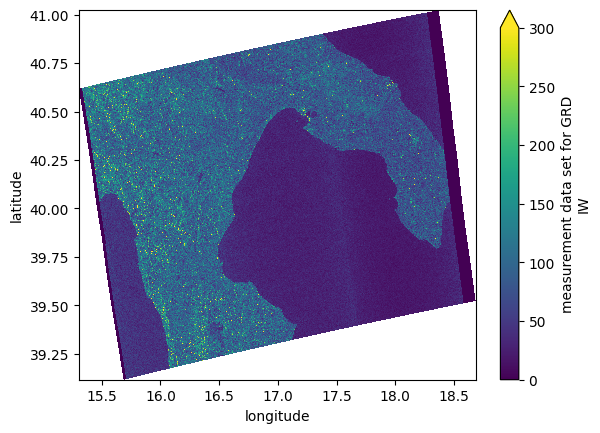

In [33]:
grd.plot(x="longitude", y="latitude", vmax=300)
plt.show()

## Calibrating intensity and amplitude

In **Sentinel-1 GRD** products, only the amplitude of the signal is stored, while the phase information is discarded, unlike Single Look Complex (SLC) products, which preserve both. Therefore, it is essential to calibrate the amplitude using the raw Digital Number (DN) values and the additional metadata provided in the `calibration` subgroup, with components such as `beta_nought`, `gamma` and `sigma_nought`.

The relationship between intensity and amplitude is given by:
$$
\text{Intensity} = |\text{Amplitude}|^2
$$


### Setting calibrtion subgroup

In [34]:
calibration = dt["/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality/calibration"].to_dataset()
calibration

<xarray.Dataset> Size: 292kB
Dimensions:       (azimuth_time: 27, ground_range: 657)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 216B 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 5kB 0.0 6.677e+06 ... 4.38e+09
    line          (azimuth_time) uint32 108B dask.array<chunksize=(27,), meta=np.ndarray>
    pixel         (ground_range) uint32 3kB dask.array<chunksize=(657,), meta=np.ndarray>
Data variables:
    beta_nought   (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    dn            (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    gamma         (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    sigma_nought  (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>

### Intensity calibration

For the intensity calibration we need to use `sigma_nought` component because it's the one that presents the backscatter normalized to ground-range area, taking into consideration the true geometry of the terrain.

We could use the `calibrate_intensity` method from the `xarray_sentinel` library but, because of the way the `zarr` values are stored and the existence of some incorrect values on the `sigma_nought` component, we can not use this useful library on this stage. 

On the other hand, we can simulate the intensity calibration using the `sigma_nought` component manually, using the `line` and `pixel` dimensions as reference for values interpolation - instead of using the already known `ground_range` and `azimuth_time`.

In [35]:
# sigma_nought is one of the three coefficients we could use
# we could also have used gamma or beta_nought but these two components don't take into account the incidence angle

sigma_nought = calibration.sigma_nought 
sigma_nought

<xarray.DataArray 'sigma_nought' (azimuth_time: 27, ground_range: 657)> Size: 71kB
dask.array<open_dataset-sigma_nought, shape=(27, 657), dtype=float32, chunksize=(27, 657), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 216B 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 5kB 0.0 6.677e+06 ... 4.38e+09
    line          (azimuth_time) uint32 108B dask.array<chunksize=(27,), meta=np.ndarray>
    pixel         (ground_range) uint32 3kB dask.array<chunksize=(657,), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <f4
    long_name:    sigma nought calibration vector (this array contains the co...

In [36]:
# we reacreate the sigma_nought array with line and pixel dimensions for easier interpolation
sigma_nought_line_pixel = xr.DataArray(
    data=sigma_nought.data,
    dims=["line", "pixel"],
    coords=dict(
        line=(["line"], sigma_nought.line.values),
        pixel=(["pixel"], sigma_nought.pixel.values),
    ),
)

sigma_nought_line_pixel 

<xarray.DataArray 'open_dataset-sigma_nought-8bcf01bd8af6fc59735108ba54b440fa' (
                                                                                line: 27,
                                                                                pixel: 657)> Size: 71kB
dask.array<open_dataset-sigma_nought, shape=(27, 657), dtype=float32, chunksize=(27, 657), chunktype=numpy.ndarray>
Coordinates:
  * line     (line) uint32 108B 0 668 1335 2003 2671 ... 15358 16026 16694 17361
  * pixel    (pixel) uint32 3kB 0 40 80 120 160 ... 26120 26160 26200 26238

We can see that the new array created for the `sigma_nought` component is basically the same as the "regular" sigma_nought with the exception that sigma_nought_line_pixel has as coordinates only `pixel` and `line`.

Now, we'll do the same for the `grd` variable, in order to eneable the later interpolation.

In [37]:
# just like for the sigma_nought, we reacreate the grd array with line and pixel dimensions for easier interpolation
grd_line_pixel = xr.DataArray(
    data=grd.data,
    dims=["line", "pixel"],
    coords=dict(
        line=(["line"], grd.line.values),
        pixel=(["pixel"], grd.pixel.values),
    ),
)

# we interpolate the sigma_nought with the grd geometry
sigma_nought_interp_line_pixel = sigma_nought_line_pixel.interp_like(grd_line_pixel, method="linear")

Finally we recreate the sigma_nought array with correct dimensions, adding the original `azimuth_time` and `ground_range` coordinates from the grd dataarray. This can be seen as a correct version of the `sigma_nought` component.

In [38]:
sigma_nought_interp = xr.DataArray(
    data=sigma_nought_interp_line_pixel.data,
    dims=["azimuth_time", "ground_range"],
    coords=dict(
        azimuth_time=(["azimuth_time"], grd.azimuth_time.values),
        ground_range=(["ground_range"], grd.ground_range.values),
    ),
)

Now, we just need to compute the actual values for the linear intensity: 

$$
\text{Intensity} = \frac{|S_{\rm grd}|^2}{\rm sigmaNought^2}
$$



In [39]:
intensity = ((abs(grd.astype(np.float32)) ** 2) / (sigma_nought_interp**2))
intensity

<xarray.DataArray (azimuth_time: 1670, ground_range: 2624)> Size: 18MB
dask.array<truediv, shape=(1670, 2624), dtype=float32, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

We'll also see that we can compute the intensity for with a dB scale:

$$
Intensity_{\text{dB}} = 10 \cdot \log_{10}(Intensity_{\text{linear}})
$$


In [40]:
intensity_db = 10 * np.log10(np.maximum(intensity, 1e-10))
intensity_db

<xarray.DataArray (azimuth_time: 1670, ground_range: 2624)> Size: 18MB
dask.array<mul, shape=(1670, 2624), dtype=float32, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

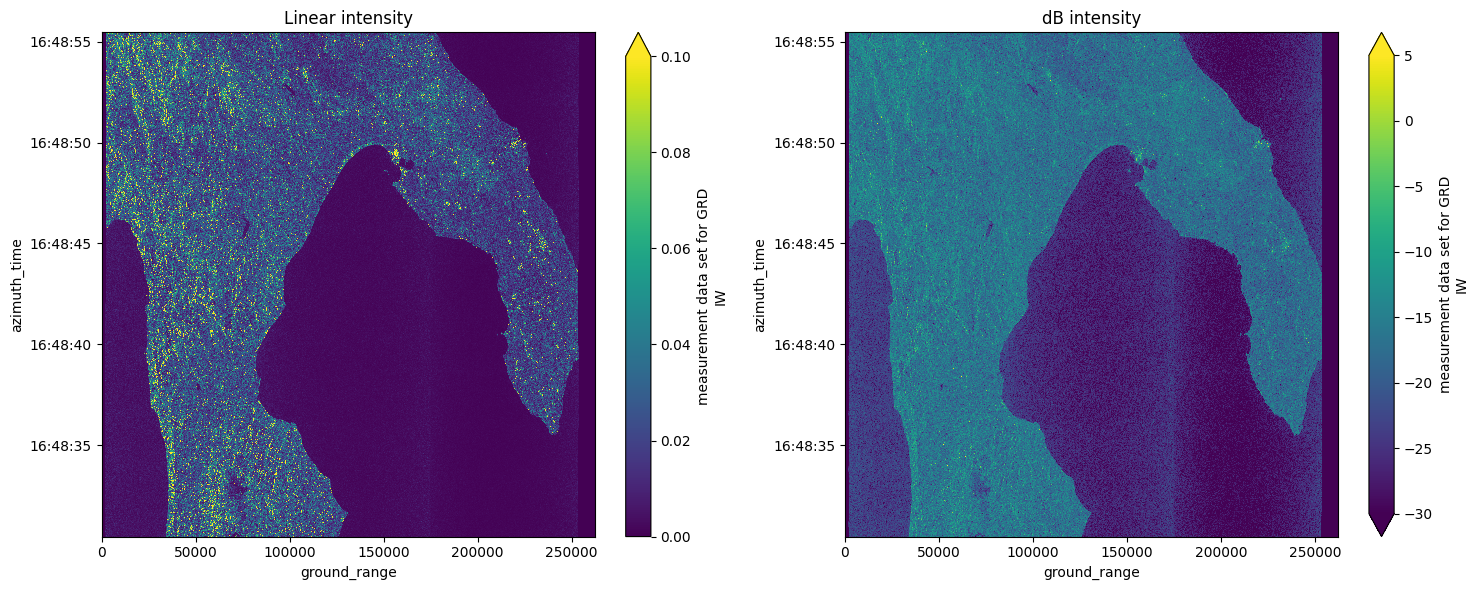

In [41]:
# plotting both linear intensity and dB intensity results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

intensity.plot(ax=axes[0], vmin=0.0, vmax=0.1)
axes[0].set_title("Linear intensity")

intensity_db.plot(ax=axes[1], vmin=-30, vmax=5)
axes[1].set_title("dB intensity")

plt.tight_layout()
plt.show()

### Amplitude calibration

In [42]:
amplitude = np.sqrt(intensity)
amplitude

<xarray.DataArray (azimuth_time: 1670, ground_range: 2624)> Size: 18MB
dask.array<sqrt, shape=(1670, 2624), dtype=float32, chunksize=(256, 2624), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 21kB 0.0 100.0 ... 2.622e+05 2.623e+05
    line          (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel         (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

In [43]:
# plotting amplitude with both linear intensity and dB intensity results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# not that we keep the same max and min values for better comparison
amplitude.plot(ax=axes[0], vmin=0.0, vmax=0.1) # changing vmax to 0.8 and removing vmin would allow to see different details
axes[0].set_title("Amplitude")

intensity.plot(ax=axes[1], vmin=0.0, vmax=0.1)
axes[1].set_title("Linear intensity")

intensity_db.plot(ax=axes[2], vmin=-30, vmax=5)
axes[2].set_title("dB intensity")

plt.tight_layout()
plt.show()

### Georeferenced intensity and amplitude

Because we had already georefefenced the images, we can now also plot theresults with `latitude` and `longitude` coordinates.

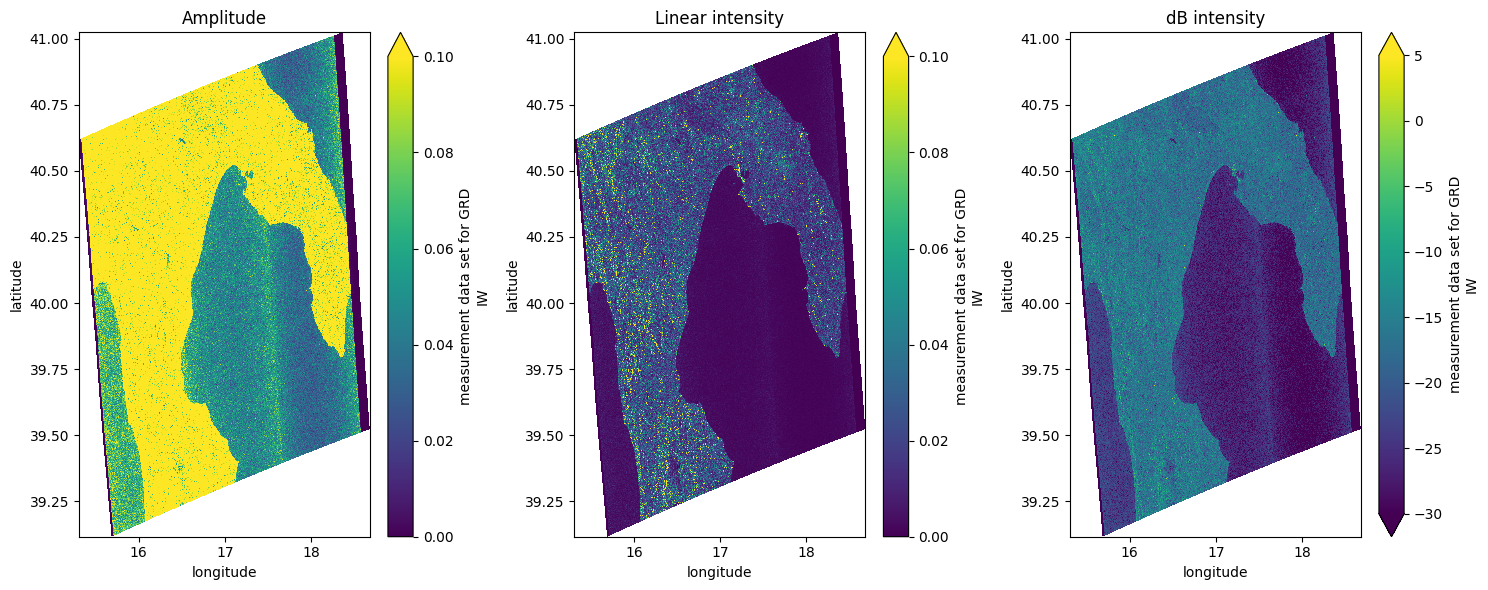

In [44]:
# plotting amplitude with both linear intensity and dB intensity results georeferenced
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

amplitude.plot(ax=axes[0], x="longitude", y="latitude", vmin=0.0, vmax=0.1) 
axes[0].set_title("Amplitude")

intensity.plot(ax=axes[1], x="longitude", y="latitude", vmin=0.0, vmax=0.1)
axes[1].set_title("Linear intensity")

intensity_db.plot(ax=axes[2], x="longitude", y="latitude", vmin=-30, vmax=5)
axes[2].set_title("dB intensity")

plt.tight_layout()
plt.show()

### Comparing results with `xarray_sentinel`

In [45]:
calibrate_amplitude = xarray_sentinel.calibrate_amplitude(
    grd, calibration.beta_nought)

calibrate_intensity = xarray_sentinel.calibrate_intensity(
    grd, calibration.beta_nought)

calibrate_intensity_db = xarray_sentinel.calibrate_intensity(
    grd, calibration.beta_nought, as_db=True)

In [46]:
# plotting amplitude with both linear intensity and dB intensity results vs with xarray_sentinel calibration functions
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

amplitude.plot(ax=axes[0, 0], vmin=0.0, vmax=0.1) 
axes[0, 0].set_title("Amplitude")

intensity.plot(ax=axes[0, 1], vmin=0.0, vmax=0.1)
axes[0, 1].set_title("Linear intensity")

intensity_db.plot(ax=axes[0, 2], vmin=-30, vmax=5)
axes[0, 2].set_title("dB intensity")

calibrate_amplitude.plot(ax=axes[1, 0], vmin=0.0, vmax=0.1) 
axes[1, 0].set_title("Amplitude with xarray_sentinel")

calibrate_intensity.plot(ax=axes[1, 1], vmin=0.0, vmax=0.1)
axes[1, 1].set_title("Linear intensity with xarray_sentinel")

calibrate_intensity_db.plot(ax=axes[1, 2], vmin=-30, vmax=5)
axes[1, 2].set_title("dB intensity")

plt.tight_layout()
plt.show()

<hr>

## 💪 Now it is your turn

The following exercises will help you to better understand the calibration processes studied before.

### Task 1: Reproduce this workflow on a different area
Using what you’ve already learned about the STAC catalog and Sentinel-1 GRD products, repeat this workflow with a different Sentinel-1 GRD scene. Try to use a scene from the area where you live, just like you did on the previous chapter. Then, observe how the geographical coordinates of the georeferenced image differ between products.

### Task 2: Explore intensity and amplitude values
Discover what happens when the maximum and minimum value on x and y axis change. These will create new results, especially when considering the plots on amplitude and intensity calibration.

### Task 3: Compare the intensity values with other datasets
Try to calibrate and plot some grd products from other datasets and see how the intensity values change over different areas, textures and surfaces.


## Conclusion

During this tutorial we've learnt how to compute amplitude and intensity calibration on Sentinel-1 GRD data and how to georeference `measurements.grd` variable into geographical coordinates. 

## What's next?

Now that you have been introduced to the `.zarr` encoding format, learned its core concepts, and understood the basics of how to explore it, you are prepared for the next step. In the following [chapter](./24_zarr_struct_S2L2A.ipynb) we will introduce you to the [Sentinel-2 L-2A](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-2-l2a) `.zarr` structure. As we go along, we are more and more transition from theory to practice, providing you with hands-on tutorials working with EOPF `.zarr` products.